# Week 7

***1.*** Plot an overlay with the output of the predictions using a synthetic set. Repeat the plot using several NN architectures and note the changes of the plot. Try these architectures: _Not Complete_

> ***a.*** 1 hidden layer with just 1 neuron (it would probably produce two lines)  [Go to](#part1a)

> ***b.*** 1 hidden layer with 2 neurons (it would probably produce three lines) [Go to](#part1b)

> ***c.*** 1 hidden layer with 10 neurons [Go to](#part1c)

> ***d.*** The best architecture you found using the previous experiments [Go to](#part1d) 

***2.*** Incorporate categorical data (on your request). [Go to](#part2) _Not Complete_

***3.*** Bring some possible data sets for text classification. We can use them for the next sessions. [Go to](#part) 

***Problem reports***: [Go to](#bugs)

In [1]:
import logging
logging.getLogger('tensorflow').disabled = True

import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn import metrics 

import numpy as np
import pandas as pd

import math

from matplotlib import cm, gridspec
from matplotlib import pyplot as plt

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<a id='part1a'></a>

# Task 1

### The set up

In [2]:
%matplotlib inline
df = pd.read_csv('data/Family Income and Expenditure.csv')

import re

if "Total Food Expenditure" in list(df):    
    df = df.drop("Total Food Expenditure", 1)
reg = re.compile('.*(([Ee]xpenditure)|([Ee]xpenses))$')
expenditure_types = [var for var in list(df) if re.match(reg, var)]
df["TotalExpenditure"] = np.sum(df[expenditure_types],1)

reg_number = re.compile('Number.*')
reg_house = re.compile('House .*')
reg_type = re.compile('Type .*')

remove = [var for var in list(df) if re.match(reg_number, var) 
                                  or re.match(reg_house, var) 
                                  or re.match(reg_type, var)]  + expenditure_types

for var in remove:
    if var in list(df):
        df = df.drop(var, 1)

df = df.rename(index=str, columns={var:(re.sub('[\s+]', '', var))for var in list(df)})

### Defining features and targets

In [3]:
df = df.reindex(np.random.permutation(df.index))

X = df[["HouseholdHeadAge"]]
X_attr = [tf.feature_column.numeric_column("HouseholdHeadAge")]
y = df["TotalExpenditure"]

### Splitting the data

In [4]:
split_sizes = {
    "train":int(len(df)*0.7),
    "dev":math.ceil(len(df)*0.15),
    "test":math.ceil(len(df)*0.15),
}
train = dict()
dev = dict()
test = dict()
train['X'], dev['X'], test['X'] = tf.split(X, 
                          [split_sizes["train"], 
                           split_sizes["dev"],
                           split_sizes["test"]],
                           0)

train['y'], dev['y'], test['y'] = tf.split(y, 
                          [split_sizes["train"], 
                           split_sizes["dev"],
                           split_sizes["test"]],
                           0)

### Input Function

In [5]:
def input_fn(X, X_name, y, batch_size=1, shuffle=True, num_epochs=None):    
    ds = Dataset.from_tensor_slices(({X_name:X}, y))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle: ds = ds.shuffle(buffer_size=10000)
    
    return ds.make_one_shot_iterator().get_next()

<a id='part1a'></a>
*Here goes nothing...*
## PART A
#### Defining new sample
_Which is just a range of integers from 10 to 90 inclusive._

In [6]:
new_sample = np.arange(10,91)

#### Defining input function

In [7]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'HouseholdHeadAge': new_sample},
    num_epochs=1,
    shuffle=False
)

### 1 Layer, 1 Neuron

In [22]:
optim = tf.train.GradientDescentOptimizer(learning_rate=20)
optim = tf.contrib.estimator.clip_gradients_by_norm(optim, 5.0)
dnn_reg = tf.estimator.DNNRegressor(
    feature_columns=X_attr,
    optimizer=optim,
    hidden_units = [10, 10]
)

dnn_reg.train(
    lambda:input_fn(train['X'],'HouseholdHeadAge', train['y']),
    steps=100
)

In [25]:
pred_generator = dnn_reg.predict(
    input_fn=pred_input_fn
)
y_pred = np.array([p['predictions'][0] for p in pred_generator])

**Bug encountered** 

[Goto report](#plotproblem) 

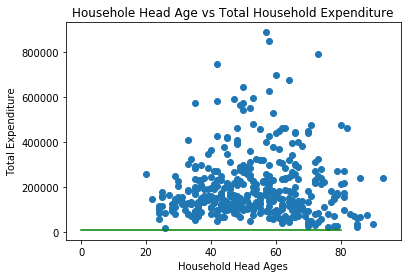

In [29]:
sample = df.sample(400)

x_0 = sample["HouseholdHeadAge"].min()
x_1 = sample["HouseholdHeadAge"].max()

plt.title("Househole Head Age vs Total Household Expenditure")
plt.ylabel("Total Expenditure")
plt.xlabel("Household Head Ages")

plt.plot(y_pred, color='green')
plt.scatter(sample["HouseholdHeadAge"], sample["TotalExpenditure"])

plt.show()

<a id='part3'></a>
# Part 3

Some possible text classification data sets I have found are.

- [TED Persuasion dataset](https://data.world/owentemple/text-and-content-features-of-most-persuasive-ted-talks):

Looks very interesting for sentiment analysis. Features include amounts of people rating the TED Talk as persuasive, inspiring or unconvincing and normalised versions of those. It's a very robust dataset, but a lot of the Talks are missing transcripts.

At only a shape of (2406, 188), it might be a very constricted dataset.

[I found a better version of this dataset](https://www.kaggle.com/rounakbanik/ted-talks/data)

- [Myer's Briggs and comments](https://www.kaggle.com/datasnaek/mbti-type/data)

Features are only text data, and the user's personality type.

- [Wine Review Data](https://www.kaggle.com/zynicide/wine-reviews/data)

A very popular and standard dataset, but fairly powerful.

- [Wordcloud of matches in a popular multiplayer game](https://www.kaggle.com/helloworldisenough/dota-2-allchat-wordcloud/data)

Slightly less standard as a lot of different variables not just text may change the outcome of a game.

- [News articles](https://www.kaggle.com/snapcrack/all-the-news/data)

Only text and nothing else for predictive model creation.

<a id="bugs"></a>
<font color='red'>
# Issues encountered
</font>
_all legacy code_


### Issue 1
_from Part 1_

"shows that to input into the neural network, we must:
1. Start a session 
    - from what I see, it seems like the session is essentially like a `matplotlib` object
2. Define a `feed_dict`, which is set up like this:
    - { X_desc : Xi }
    - Where:
        - X_desc : desciptions of the predictor in `tf.placeholder` format
            - From my understanding `tf.placeholder` is like a way to feed data to our graph
        - Xi : our input, (numpy array's, lists etc.)
3. Shove this all into Python as `tf.Session().run(pred_generator, feed_dict)`

We need this to make the plots.

[Found on Stanford's CS224d tute on TF](https://cs224d.stanford.edu/lectures/CS224d-Lecture7.pdf)."

**Code**
```
input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)

output_fn = tf.multiply(input1, input2)

with tf.Session() as sess: 
    print(sess.run(output_fn, 
                   feed_dict={input1:[45], 
                              input2:[10]}))
```
**Resolution**

TensorFlow `generator` type is not taken by `sess.run()`. Instead, must directly use `estimator.predict()`.

<a id='plotproblem'></a>
### Issue 2
_from part 1_

```python 
>>> optim = tf.train.GradientDescentOptimizer(learning_rate=20)
>>> optim = tf.contrib.estimator.clip_gradients_by_norm(optim, 5.0)
>>> dnn_reg = tf.estimator.DNNRegressor(
        feature_columns=X_attr,
        optimizer=optim,
        hidden_units = [1]
)

>>> dnn_reg.train(
        lambda:input_fn(train['X'], 'HouseholdHeadAge', train['y']),
        steps=100
)

>>> pred_generator = dnn_reg.predict(
        input_fn=pred_input_fn
)

>>> for p in pred_generator:
        print(p)
```
Produces: 
```
{'predictions': array([9801.488], dtype=float32)}
{'predictions': array([9801.488], dtype=float32)}
{'predictions': array([9801.488], dtype=float32)}
...
```

**Debugging**
```
tf.Session().run(tf.Print(train['X'], [train['X']]))
```

Produces:
```
array([[58],
       [69],
       [53],
       ...,
       [59],
       [52],
       [60]], dtype=int64)
```

With also expected values from `train['y']`, so it can't be due to the splitting.

**Resolution**

Comparing it with last weeks code.

Printing out the same prediction yield almost identical results and still give a valid result, which means that either I'm miss understanding how `.predict()` works, or it's a bug by TF.

One further research, from last week, our values were also invalid as:

![](screenshots/Week7Part1Bug.jpg)


### Issue 3
_from Part 1_

**EDIT:** In the beginning, I used this:

```python
def input_fn_pred(X, labels=None, batch_size=1):
    if labels == None:    inputs = X
    else:    inputs = (X, labels)
        
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    
    dataset = dataset.batch(batch_size)
    
    return dataset.make_one_shot_iterator().get_next()
```

**Resolution** 

But it always returned, one singular value whenever I passed a list or a `np.array` into it.

So I decided to jump to using `tf.estimator.inputs.numpy_input_fn`, and there hasn't been any input_fn problems.
